In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os 
import tensorflow as tf
%matplotlib inline

plt.rcParams['figure.figsize'] = (8, 8)

In [2]:
# Some constants  
DATA_PATH = '/home/upul/datasets/udacity/debug/'
LABEL_FILE_NAME = 'labels.csv'
GRIDS_PER_DIR = 8
BATCH_SIZE = 2

IMG_SIZE = (1200, 1920, 3)

In [3]:
dataset = pd.read_csv(os.path.join(DATA_PATH, LABEL_FILE_NAME))
# printing some examples ....
dataset.head(5)

dataset['xmax_tmp'] = dataset['xmax']
dataset['ymin_tmp'] = dataset['ymin']

dataset['xmax'] = dataset['ymin_tmp']
dataset['ymin'] = dataset['xmax_tmp'] 

(1200, 1920, 3)


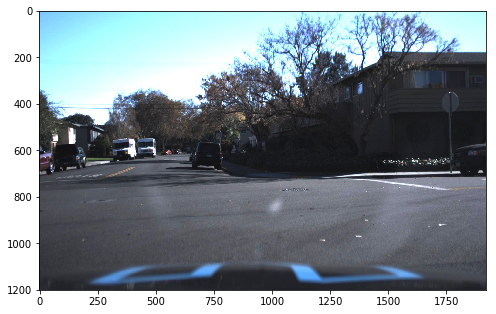

In [4]:
path = os.path.join(DATA_PATH, '1479498373962951201.jpg')
img = plt.imread(path)
print(img.shape)
plt.imshow(img)
plt.show()

In [5]:
np.random.seed(1024)
unique_frames = dataset['Frame'].unique()
mask = np.random.rand(len(unique_frames)) > 0.5
train_ids = unique_frames[mask]
test_ids = unique_frames[~mask]

train = dataset[dataset['Frame'].isin(train_ids)]
test = dataset[dataset['Frame'].isin(test_ids)]
print('Number of images in train: {}'.format(len(train)))
print('Number of images in test: {}'.format(len(test)))

Number of images in train: 54
Number of images in test: 23


In [6]:
def get_bounding_boxes(data, frame_name):
    bb_info = data[data['Frame'] == frame_name][['xmin', 'xmax', 'ymin', 'ymax']]
    bb_list = []
    for i in range(len(bb_info)):
        row = bb_info.iloc[i]
        bb_list.append(((row[0], row[2]), (row[1], row[3])))
    return bb_list

boundings = get_bounding_boxes(train, '1479498373962951201.jpg')

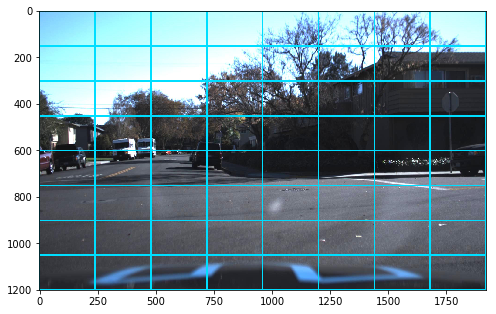

In [7]:
def get_grids(img):
    assert isinstance(img, np.ndarray)
    data = img[:, :, 0]
    x_pix_per_block = data.shape[1] // GRIDS_PER_DIR
    y_pix_per_block = data.shape[0] // GRIDS_PER_DIR

    all_grids = []
    for i in range(0, GRIDS_PER_DIR):  # X dir
        for j in range(0, GRIDS_PER_DIR):  # Y dir
            all_grids.append((i*x_pix_per_block, j*y_pix_per_block))
    return all_grids


def plt_grids(image, grids):
    data = img[:, :, 0]
    x_pix_per_block = data.shape[1] // GRIDS_PER_DIR
    y_pix_per_block = data.shape[0] // GRIDS_PER_DIR
    
    for grid in grids:
        i = grid[0]
        j = grid[1]
        cv2.rectangle(image, (i, j), (i+x_pix_per_block, j+y_pix_per_block), color=[0, 222, 255], thickness=5)    
    plt.imshow(image)

grids = get_grids(img)
plt_grids(img, grids)

8


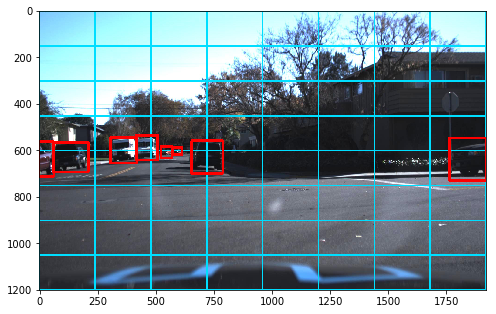

In [8]:
def display_bounding_boxes(image, boundings):   
    print(len(boundings))
    for box in boundings:
        cv2.rectangle(image, box[0], box[1], color = (255, 0, 0), thickness=10)
    plt.imshow(image)       
display_bounding_boxes(img, boundings)                                       

In [9]:
def do_overlap(grid, box, x_pix_per_block, y_pix_per_block):
    grid_top_left = (grid[0], grid[1])
    grid_bot_right =  (grid[0] + x_pix_per_block, grid[1] + y_pix_per_block)
    if grid_bot_right[0] < box[0][0] or grid_top_left[0] > box[1][0]:
        return False
    if grid_bot_right[1] < box[0][1] or grid_top_left[1] > box[1][1]:
        return False
    return True

def convert_to_numpy(frame, img_name):
    boundings = get_bounding_boxes(frame, img_name)
    path = os.path.join(DATA_PATH, img_name)
    img = plt.imread(path)
    grids = get_grids(img)
    
    data = img[:, :, 0]
    x_pix_per_block = data.shape[1] // GRIDS_PER_DIR
    y_pix_per_block = data.shape[0] // GRIDS_PER_DIR
    
    label = np.zeros((GRIDS_PER_DIR, GRIDS_PER_DIR))
    for grid in grids:
        for box in boundings:
            if do_overlap(grid, box, x_pix_per_block, y_pix_per_block):
                i = grid[1] // y_pix_per_block
                j = grid[0] // x_pix_per_block
                label[i, j] = 1
    return img, label

_, label = convert_to_numpy(train, '1479498373962951201.jpg')
print(label)

[[ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  1.  1.  1.  0.  0.  0.  1.]
 [ 1.  1.  1.  1.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]]


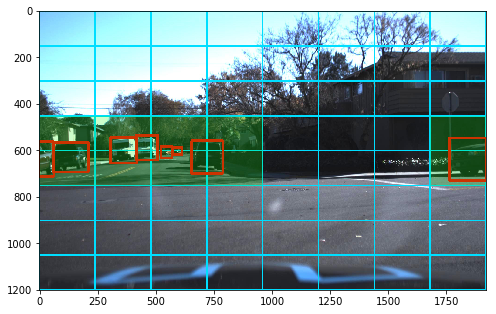

In [10]:
def display_overlap_grids(image, label):
    data = img[:, :, 0]
    x_pix_per_block = data.shape[1] // GRIDS_PER_DIR
    y_pix_per_block = data.shape[0] // GRIDS_PER_DIR
    
    copy = image.copy()
    for i in range(0, GRIDS_PER_DIR):  # X dir
        for j in range(0, GRIDS_PER_DIR):  # Y dir
            if label[i, j] == 1:
                cv2.rectangle(copy, 
                              (j*x_pix_per_block, i*y_pix_per_block), 
                              (j*x_pix_per_block + x_pix_per_block, i*y_pix_per_block + y_pix_per_block),
                              color=[0, 255, 0],
                              thickness = -1)
    alpha = 0.2
    cv2.addWeighted(copy, alpha, image, 1 - alpha, 0, image)
    plt.imshow(image)

display_overlap_grids(img, label)

In [11]:
def get_batch_frame(training, batch_size):
    unique_ids = train['Frame'].unique()
    batch_ids = np.random.choice(len(unique_ids), BATCH_SIZE, replace=False)
    batch_frame = unique_ids[batch_ids]
    return train[train['Frame'].isin(batch_frame)]

batch_frame = get_batch_frame(train, batch_size=BATCH_SIZE)

In [12]:
def batch_to_numpy(frame):
    img_names = frame['Frame'].unique()
     
    batch  = []
    labels = []
    
    for img_name in img_names:
        img, label = convert_to_numpy(frame, img_name)
        batch.append(img)
        labels.append(label)
    return np.array(batch), np.array(labels)

batch_X, batch_y = batch_to_numpy(batch_frame)
print(batch_X.shape)
print(batch_y.shape)

(2, 1200, 1920, 3)
(2, 8, 8)


In [13]:
def sigmoid_cross_entropy_with_logits_2d(labels, logits):
    entropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=labels, logits=logits)
    return tf.reduce_mean(entropy, name='loss')

lbl = np.array([np.array([[1, 0], [0, 1]]), np.array([[0, 0], [1, 1]])])
log = np.array([np.array([[0.8, 0.2], [0.0, 0.77]]), np.array([[0.01, 0.9], [0.99, 0.12]])])

place_labels = tf.placeholder(tf.float32, [2, 2, 2], name='place_labels')
place_logits = tf.placeholder(tf.float32, [2, 2, 2], name='place_logits')

loss = sigmoid_cross_entropy_with_logits_2d(labels=place_labels, logits=place_logits)
with tf.Session() as sess:
    output = sess.run([loss], feed_dict={place_labels: lbl, place_logits: log})
    print(output)

[0.64163816]
